In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from torch import Tensor, nn, optim
from torch.utils.data import TensorDataset, DataLoader

from gbi.benchmark.tasks.linear_gaussian.task import LinearGaussian
from gbi.benchmark.tasks.two_moons.task import TwoMoonsGBI
from gbi.benchmark.tasks.gaussian_mixture.task import GaussianMixture
from gbi.utils import utils as gbi_utils
from gbi.GBI import GBInference
from gbi.distances import mse_dist, mmd_dist
from scipy.stats import pearsonr

ModuleNotFoundError: No module named 'sbibm'

In [11]:
import sys
sys.path.append('../')
import gbi
from gbi.utils import utils as gbi_utils
from gbi.benchmark.tasks.gaussian_mixture.task import GaussianMixture

In [9]:
task = GaussianMixture()
theta = task.prior.sample((100,))
x = task.simulate(theta)
x_target = task.simulate(task.prior.sample((110,)))

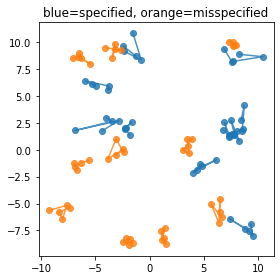

In [69]:
cm = 1#1/2.54
plt.figure(figsize=(4*cm,4*cm))
xo_type=('misspecified', 'known')
for i_s,s in enumerate(['specified', 'misspecified']):
    # for i_k,k in enumerate(['known', 'unknown']):
    i_k=0; k='known'
    xos = gbi_utils.pickle_load(f'../gbi/benchmark/tasks/gaussian_mixture/xos/xo_{s}_{k}.pkl')
    for xo in xos:
        plt.plot(xo[:,0],xo[:,1], color=f'C{i_s}', marker='o' if i_k==0 else '*', label=s, alpha=0.8)

plt.title('blue=specified, orange=misspecified', fontsize=12)
plt.tight_layout()
# plt.savefig('tester.svg', transparent=True)


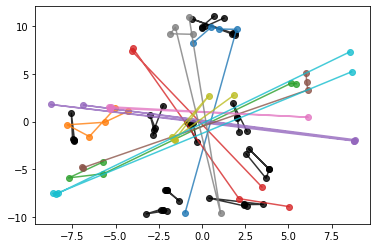

In [153]:
task = GaussianMixture(seed=50)
xs = task.simulate(task.prior.sample((10,)))
xm = task.simulate_misspecified(task.prior.sample((10,)))
for x in xs:
    plt.plot(x[:,0],x[:,1], 'ko-', alpha=0.8)
    
for x in xm:
    plt.plot(x[:,0],x[:,1], 'o-', alpha=0.8)

In [106]:
gbi = GBInference(task.prior, mmd_dist, do_precompute_distances=True)
gbi.append_simulations(theta, x, x_target)
gbi.initialize_distance_estimator(5, 64)

Pre-computing distances... finished in 5.033197402954102 seconds.


In [108]:
gbi.train(n_train_per_theta=1, n_val_per_theta=-1, max_n_epochs=1000);

RuntimeError: Tensors must have same number of dimensions: got 2 and 3

In [200]:
task = GaussianMixture()
theta = task.prior.sample((100,))
x = task.simulate(theta)


tensor([[10, 71],
        [11, 42],
        [12, 77],
        [13, 84],
        [14, 83],
        [15, 82],
        [16, 86],
        [17, 59],
        [18, 40],
        [19, 54]])

In [36]:
inference = gbi_utils.pickle_load('../results/benchmark/algorithms/two_moons/2023_04_08__12_42_12/GBI/inference.pickle')
# inference = gbi_utils.pickle_load('../results/benchmark/algorithms/two_moons/2023_04_08__12_42_12/GBI/inference.pickle')
posterior_samples = gbi_utils.pickle_load('../results/benchmark/algorithms/two_moons/2023_04_08__12_42_12/posterior_samples_all.pkl')
posterior_predictives = gbi_utils.pickle_load('../results/benchmark/algorithms/two_moons/2023_04_08__12_42_12/posterior_predictives_all.pkl')

{'theta': tensor([[-0.9613, -0.9717],
         [ 0.8848,  0.9145],
         [ 0.9983,  0.9767],
         ...,
         [ 0.8262,  0.9832],
         [-0.8286, -0.9685],
         [ 0.9578,  0.8241]]),
 'x_pred': tensor([[-1.0367e+00, -8.2730e-03],
         [-9.5138e-01,  1.0058e-01],
         [-1.1197e+00, -1.0916e-01],
         ...,
         [-9.4670e-01,  2.9459e-02],
         [-9.0484e-01, -1.3668e-01],
         [-1.0041e+00,  4.1570e-04]]),
 'dist_gt': tensor([0.0347, 0.0625, 0.0278,  ..., 0.0653, 0.0687, 0.0713]),
 'dist_samples': tensor([0.0360, 0.0671, 0.0236,  ..., 0.0644, 0.0900, 0.0452]),
 'dist_estimate': tensor([0.0298, 0.0624, 0.0407,  ..., 0.0366, 0.0586, 0.0911])}

In [59]:
# plt.plot(ps[2]['GT']['beta_100']['dist_gt'], ps[2]['GT']['beta_1000']['dist_samples'], '.')

(0, 'specified', 'known'): 0.7494717320294983
(0, 'specified', 'unknown'): 0.9182131177553224
(0, 'misspecified', 'known'): 0.6579654185472256
(0, 'misspecified', 'unknown'): 0.7860088342324071
(1, 'specified', 'known'): 0.6955380410053075
(1, 'specified', 'unknown'): 0.8948553828501756
(1, 'misspecified', 'known'): 0.8672237518268943
(1, 'misspecified', 'unknown'): 0.8171411682627312


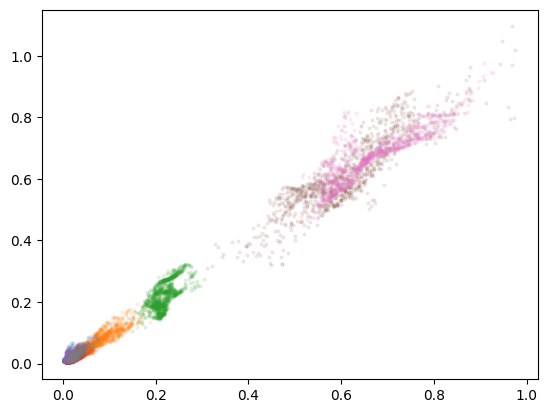

In [68]:
for ii in range(8):
    # ps = posterior_samples[ii]
    ps = posterior_predictives[ii]#[2]['GT']['beta_1000']

    print(ps[0], end=': ')
    alg='GT'
    beta='beta_100'

    theta = ps[2][alg][beta]['theta'][:1000]    
    dist_saved_gt = ps[2][alg][beta]['dist_gt'][:1000]
    dist_saved_samples = ps[2][alg][beta]['dist_samples'][:1000]
    dist_saved_estimate = ps[2][alg][beta]['dist_estimate'][:1000]
    
    xo = ps[1]['xo']
    task = TwoMoonsGBI(x_o=xo)
    # theta = task.prior.sample((1000,))
    # x = task.simulate(theta)

    dist_pred = inference.predict_distance(theta,xo.unsqueeze(0))
    dist_gt = task.distance_fn(theta)
    dists_samples_iid = torch.stack([((task.simulate(theta) - xo)**2).mean(1) for _ in range(1000)], dim=1).mean(1)

    # plt.plot(dists_samples_iid, dist_gt, '.', alpha=0.1, ms=4)
    # print(pearsonr(dists_samples_iid, dist_gt)[0])
    
    plt.plot(dist_saved_gt, dist_pred, '.', alpha=0.1, ms=4)
    print(pearsonr(dist_saved_gt, dist_pred)[0])

0.9932996329793355


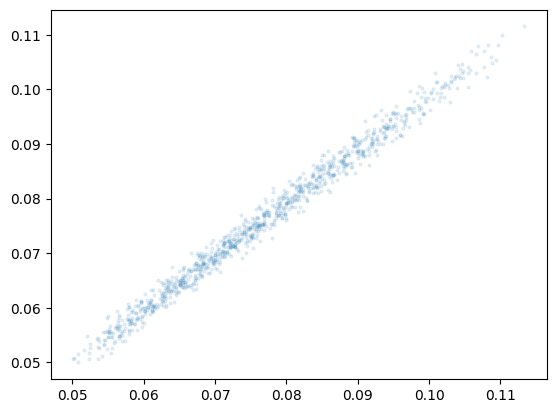

In [30]:


# plt.plot(dist_pred, dist_gt, '.')
# print(pearsonr(dist_pred, dist_gt)[0])

In [ ]:

dist

In [14]:
task = LinearGaussian(None)
theta = task.prior.sample((10000,))
x = task.simulate(theta)

x_os_augment = task.simulate(task.prior.sample((100,)))
x_target = gbi_utils.concatenate_xs(x, x_os_augment)

In [20]:
inference = GBInference(prior=task.prior, distance_func=mse_dist)
inference = inference.append_simulations(theta, x, x_target)
inference.initialize_distance_estimator(
    num_layers=5,
    num_hidden=64,
)

In [42]:
dataset = TensorDataset(torch.arange(len(theta)))

In [43]:
validation_fraction = 0.1
train_set, val_set = torch.utils.data.random_split(
    dataset,
    (Tensor([1 - validation_fraction, validation_fraction]) * len(dataset)).to(
        int
    ),
)

In [44]:
dataloader = DataLoader(train_set, batch_size=50, shuffle=True)

In [70]:
# len(train_set.indices)
torch.ones((10,)).multinomial(5, replacement=False)

tensor([0, 5, 7, 1, 2])

In [73]:
torch.cartesian_prod(torch.arange(5), torch.arange(6,8))

tensor([[0, 6],
        [0, 7],
        [1, 6],
        [1, 7],
        [2, 6],
        [2, 7],
        [3, 6],
        [3, 7],
        [4, 6],
        [4, 7]])